In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap # <-- Our new library

# We'll need all our modeling tools again
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from joblib import parallel_backend

# Set display options and plot style
pd.set_option('display.max_columns', 100)
%matplotlib inline
sns.set_style("whitegrid")

print("Imports complete. SHAP is ready.")

Imports complete. SHAP is ready.


In [ ]:
# 1. LOAD DATA
data_path = '../data/cleaned_loan_data.parquet'
df = pd.read_parquet(data_path)

# 2. FEATURE ENGINEERING (One-Hot Encoding)
features_to_drop = [
    'sub_grade', 'issue_d', 'loan_status', 'last_pymnt_d'
]
df_model = df.drop(columns=features_to_drop)
categorical_cols = ['grade', 'home_ownership', 'purpose']
df_model_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# 3. PREPARE SURVIVAL DATA (X and y)
X = df_model_encoded.drop(columns=['event', 'duration_months'])
y_temp = df_model_encoded[['event', 'duration_months']]
y = np.array(
    list(zip(
        y_temp['event'].astype(bool), 
        y_temp['duration_months'].astype(float)
    )),
    dtype=[('event', '?'), ('time', '<f8')]
)

# 4. TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 5. SUBSAMPLE
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, 
    train_size=0.10, # The 10% efficient sample
    random_state=42, 
    stratify=[e for e, t in y_train]
)

print(f"Data ready. Training on {X_train_sample.shape[0]} samples.")

Data ready. Training on 106693 samples.


In [ ]:
print("Training the 10% (efficient) model in 'silent mode'...")

rsf = RandomSurvivalForest(
    n_estimators=100,      
    min_samples_leaf=1000, 
    n_jobs=-1,             
    random_state=42,
    verbose=0            
)

with parallel_backend('loky'):
    rsf.fit(X_train_sample, y_train_sample)

print("Efficient model trained!")

# Let's re-confirm our baseline score
c_index = rsf.score(X_test, y_test)
print(f"Model C-Index: {c_index:.4f}")

Training the 10% (efficient) model in 'silent mode'...
Efficient model trained!
Model C-Index: 0.6837


Initializing SHAP explainer...
Calculating SHAP values... This will be slow (est. ~30 minutes).


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values calculated. Generating plot...


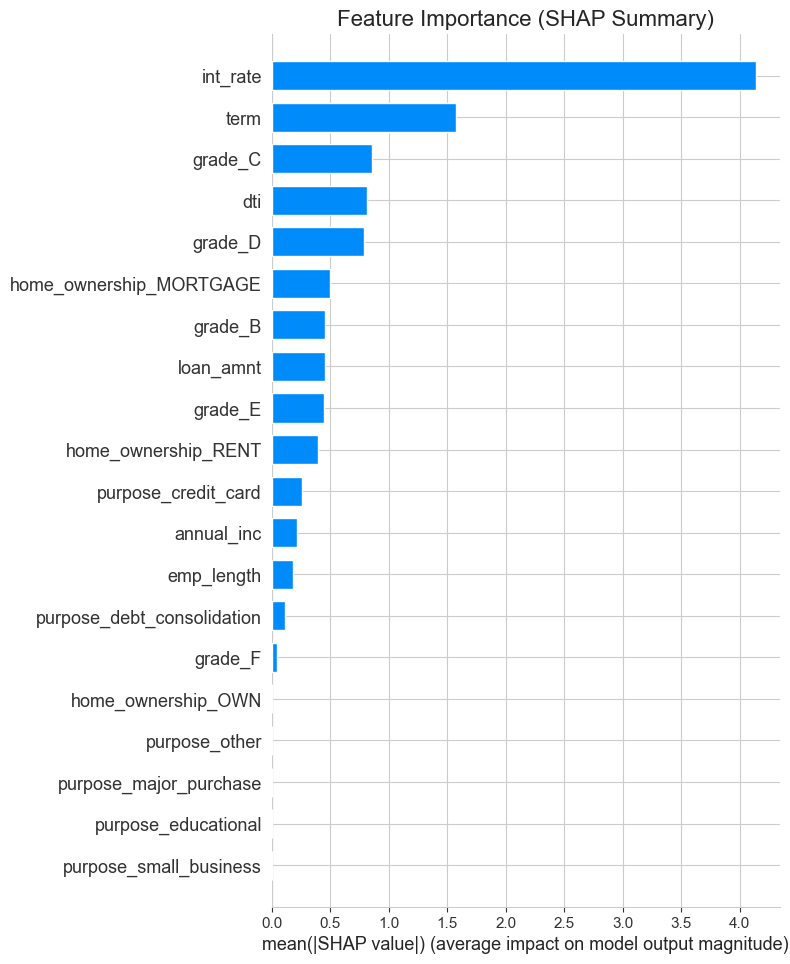

In [ ]:
import shap

print("Initializing SHAP explainer...")

# 1. SHAP needs a function that just returns a "risk score".
#    Our model's .predict() function does exactly that.
predict_fn = rsf.predict

# 2. SHAP's KernelExplainer needs a "background" dataset to learn from.
#    We'll give it a 1000-person summary of our training data.
#    This is standard practice.
X_train_summary = shap.sample(X_train_sample, 100)

# 3. Create the "explainer" tool
explainer = shap.KernelExplainer(predict_fn, X_train_summary)

# 4. Now, let's explain the predictions on a new set of 100 test samples
X_test_sample = X_test.sample(n=100, random_state=42)

print("Calculating SHAP values... This will be slow (est. ~30 minutes).")
shap_values = explainer.shap_values(X_test_sample)

print("SHAP values calculated. Generating plot...")

# 5. Create the plot! This ranks every feature by its impact.
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP Summary)", fontsize=16)
plt.show()

Performing fairness audit...


C:\Users\vandan_tank\AppData\Local\Temp\ipykernel_1684\1576918414.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  borrower_A[purpose_cols] = False
C:\Users\vandan_tank\AppData\Local\Temp\ipykernel_1684\1576918414.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  borrower_B[purpose_cols] = False


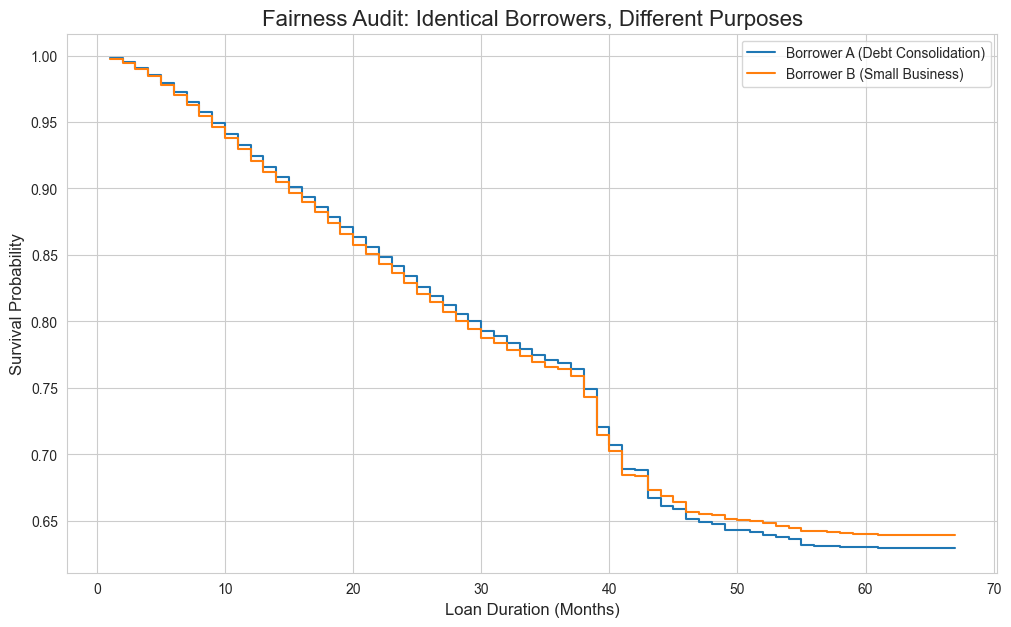

In [7]:
print("Performing fairness audit...")

# 1. Create a "baseline" borrower
# We'll take the "average" of our entire test set
baseline = X_test.mean()

# 2. Create two identical borrowers
borrower_A = baseline.copy()
borrower_B = baseline.copy()

# 3. Set the "purpose" for each borrower.
# We set one to True and all other 'purpose_' columns to False.
purpose_cols = [col for col in X.columns if col.startswith('purpose_')]
borrower_A[purpose_cols] = False
borrower_B[purpose_cols] = False

# Borrower A: Debt Consolidation
borrower_A['purpose_debt_consolidation'] = True

# Borrower B: Small Business
borrower_B['purpose_small_business'] = True

# 4. Put them into a DataFrame for the model
audit_df = pd.DataFrame([borrower_A, borrower_B])

# 5. Get survival predictions for just these two
pred_curves = rsf.predict_survival_function(audit_df)

# 6. Plot the comparison
plt.figure(figsize=(12, 7))

# Plot Borrower A
plt.step(
    pred_curves[0].x, 
    pred_curves[0].y, 
    where="post", 
    label=f"Borrower A (Debt Consolidation)"
)
# Plot Borrower B
plt.step(
    pred_curves[1].x, 
    pred_curves[1].y, 
    where="post", 
    label=f"Borrower B (Small Business)"
)

plt.title("Fairness Audit: Identical Borrowers, Different Purposes", fontsize=16)
plt.xlabel("Loan Duration (Months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.legend()
plt.show()

In [10]:
import joblib

# We are saving our final, trained 10% model (the 'rsf' object)
model_filename = 'final_survival_model.joblib'
joblib.dump(rsf, model_filename)

print(f"Champion model successfully saved to {model_filename}")

Champion model successfully saved to final_survival_model.joblib


In [11]:
# 'X_train_sample' holds the final, encoded features our model was trained on
feature_names = list(X_train_sample.columns)
joblib.dump(feature_names, 'model_feature_names.joblib')

print(f"Feature names successfully saved to model_feature_names.joblib")

Feature names successfully saved to model_feature_names.joblib
